# IBM Quantum Awards: Open Science Prize Submission
## Higher Fidelity Graph State Challenge

#### Authors: Yufeng Bright Ye[1] (brightye@mit.edu), Lingbang Zhu[2] (lzhu@g.harvard.edu)

    [1] Department of Electrical Engineering and Computer Science, MIT, Cambridge, MA, 02139
    [2] Department of Chemistry and Chemical Biology, Harvard, Cambridge, MA, 02138

In this notebook, we will prepare quantum circuits for a 7-qubit graph state on IBM Casablanca and estimate the fidelity through stabilizer measurements using Qiskit. We use the ''Complete'' method of error mitigation and repeat the graph state measurement 16 times to find statistical error bars.

### We optimized graph state fidelity with 3 strategies: 
#### I. Circuit Optimization: use parallization and gate cancellation to minimize number of gates and circuit depth; 
#### II. Gate Sequence Optimiation: preserve qubit coherence by optimizing the ordering of gates such that lower coherence qubits are activated last; and 
#### III. Dynamical Decoupling: add dynamical decoupling (echo sequence) to idling qubits to cancel unwanted correlated errors like cross-talk.

### Our main experimental result on real IBM Casablanca device was with only optimization strategy I (during February 2021, when the device had significant less error).

## Error mitigated fidelity = 96.0% +- 1.8% 

#### Note that strategies II & III were devised in late March, early April 2021, during which the IBM Casablanca chip had significant errors (IBM's default graph state circuit had fidelities << 80%), so we only provide simulator results for these. If the chip condition improves, we welcome the judges to try executing those circuits on the experimental device. We expect that they should produce further improvements to the result obtained using strategy I alone. 

## Imports

Begin by importing the necessary packages and defining the functions we will need for the stabilizer measurements.

In [1]:
### install Qiskit and other modules if you don't have them already
#!pip install -r dependencies/requirements.txt --quiet
#!pip install pylatexenc

In [2]:
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit
import qiskit.compiler.transpile as transpile

from qiskit import transpile, schedule, assemble, execute, pulse

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In order to show our experimental results, we first load the backend `ibmq_casablanca` from our own account using the `IBMQ` provider. 

In [3]:
# Load IBMQ Account data
from qiskit import IBMQ
IBMQ.save_account('2b8218f150600ba6d35be3868c1b178cce4f5139ac2d56ea06d87616b9b84fca017047b84fe28a3ceb7629ec56f36490a4e56375c081b4de68adeab5fb146c25', overwrite = 'True')
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')
properties = backend.properties()

## Experimental Results with Strategy I

### Here, we compare IBM's default graph state circuit for 7-qubits using the `GraphState` function in Qiskit's circuit library versus the optimized graph state circuit we found using Strategy I, parallelization and gate cancellation (without strategies II.  and III. yet).

#### IBM's default graph state circuit:

In [4]:
num_qubits = 7

# adjacency matrix for `ibmq_casablanca`
adjmat = [
    [0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0], 
    [0, 1, 0, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0, 1, 0], 
    [0, 0, 0, 0, 0, 1, 0], 
    [0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 0, 1, 0]]

def create_default_graph_state():
    ''' Create graph state using IBMs default circuit '''
    
    graph_state_circuit = circuit_library.GraphState(adjmat)
    
    return graph_state_circuit

state_circuit = create_default_graph_state()
state_circuit = transpile(state_circuit)
state_circuit.draw()

┌───┐                  
q_0: ┤ H ├─■────────────────
     ├───┤ │                
q_1: ┤ H ├─■──■──■──────────
     ├───┤    │  │          
q_2: ┤ H ├────■──┼──────────
     ├───┤       │          
q_3: ┤ H ├───────■──■───────
     ├───┤          │       
q_4: ┤ H ├──────────┼──■────
     ├───┤          │  │    
q_5: ┤ H ├──────────■──■──■─
     ├───┤                │ 
q_6: ┤ H ├────────────────■─
     └───┘

#### See the pulse schedule of the default graph state circuit, comes out to be about 12 us before measurement

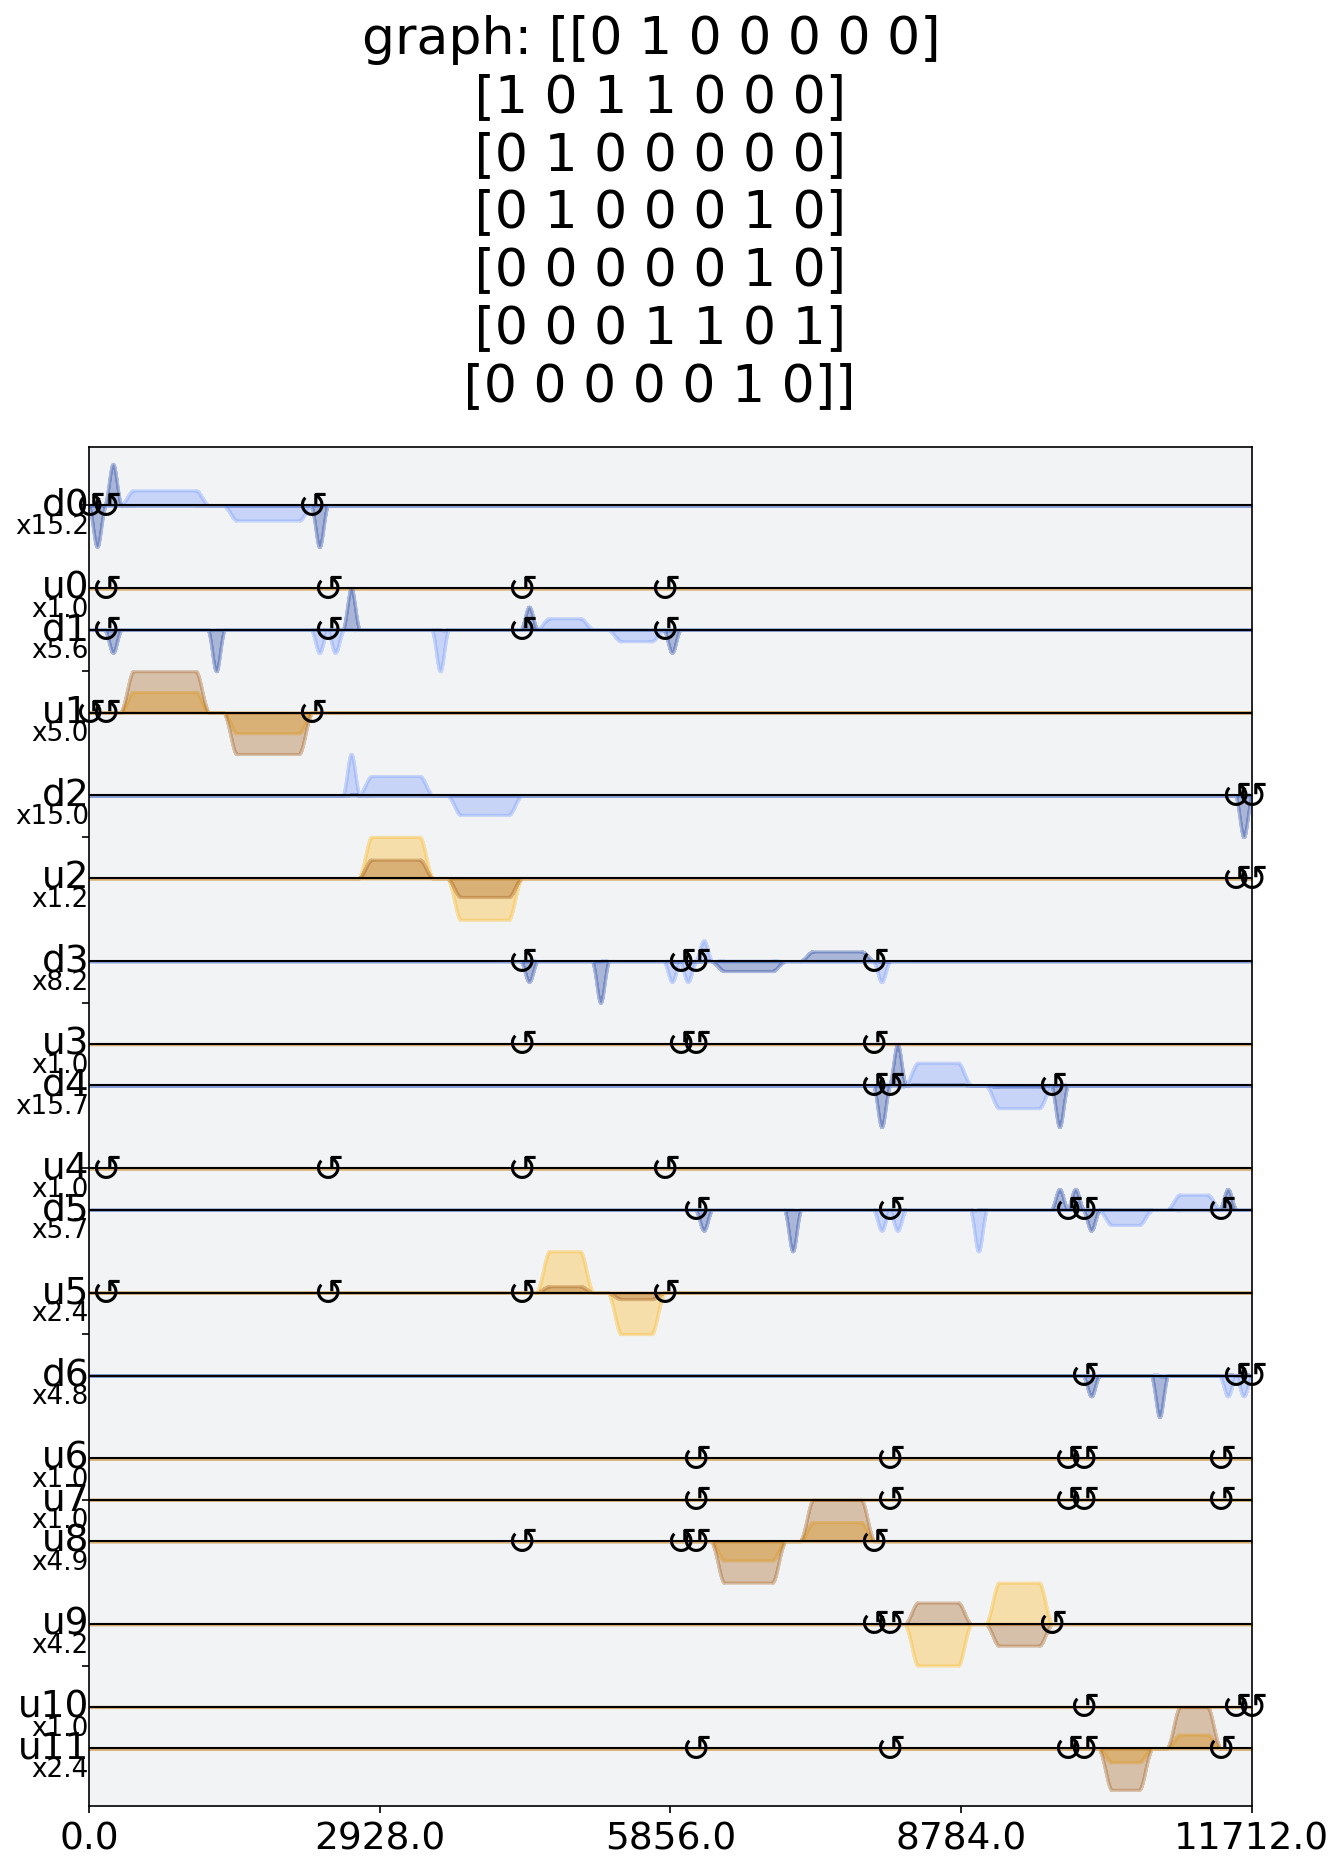

In [5]:
back_defaults = backend.defaults()

inst_map = back_defaults.instruction_schedule_map

sched = schedule(transpile(state_circuit, backend, optimization_level = 1), backend, inst_map=inst_map)
sched.draw()#plot_range=(0, 12000))


#### Our optimized graph state circuit, using parallelization and gate cancellation:

In [6]:
def create_optimized_graph_state():
    ''' Create our optimized graph state circuit with maximal parallelization and gate cancellation '''
    
    state_circuit = QuantumCircuit(7)
    state_circuit.h(0)
    state_circuit.h(2)
    state_circuit.h(3)
    state_circuit.h(4)
    state_circuit.h(6)
    state_circuit.cx(0, 1)
    state_circuit.cx(3, 5)
    state_circuit.cx(2, 1)
    state_circuit.cx(4, 5)
    state_circuit.cx(3, 1)
    state_circuit.cx(6, 5)
    state_circuit.h(1)
    state_circuit.h(5)
    
    return state_circuit

state_circuit = create_optimized_graph_state()
state_circuit.draw()

## Notice how we run two sets of CX in parallel at each level and 
## set qubit 1 and 5 such that many Hadamards (part of CZ) are cancelled there

┌───┐                    
q_0: ┤ H ├──■─────────────────
     └───┘┌─┴─┐┌───┐┌───┐┌───┐
q_1: ─────┤ X ├┤ X ├┤ X ├┤ H ├
     ┌───┐└───┘└─┬─┘└─┬─┘└───┘
q_2: ┤ H ├───────■────┼───────
     ├───┤            │       
q_3: ┤ H ├──■─────────■───────
     ├───┤  │                 
q_4: ┤ H ├──┼────■────────────
     └───┘┌─┴─┐┌─┴─┐┌───┐┌───┐
q_5: ─────┤ X ├┤ X ├┤ X ├┤ H ├
     ┌───┐└───┘└───┘└─┬─┘└───┘
q_6: ┤ H ├────────────■───────
     └───┘

#### See the pulse schedule of our optimized graph state circuit, comes out to be about 6 us before measurement, which is only HALF the depth of the default and involves  fewer single qubit gates

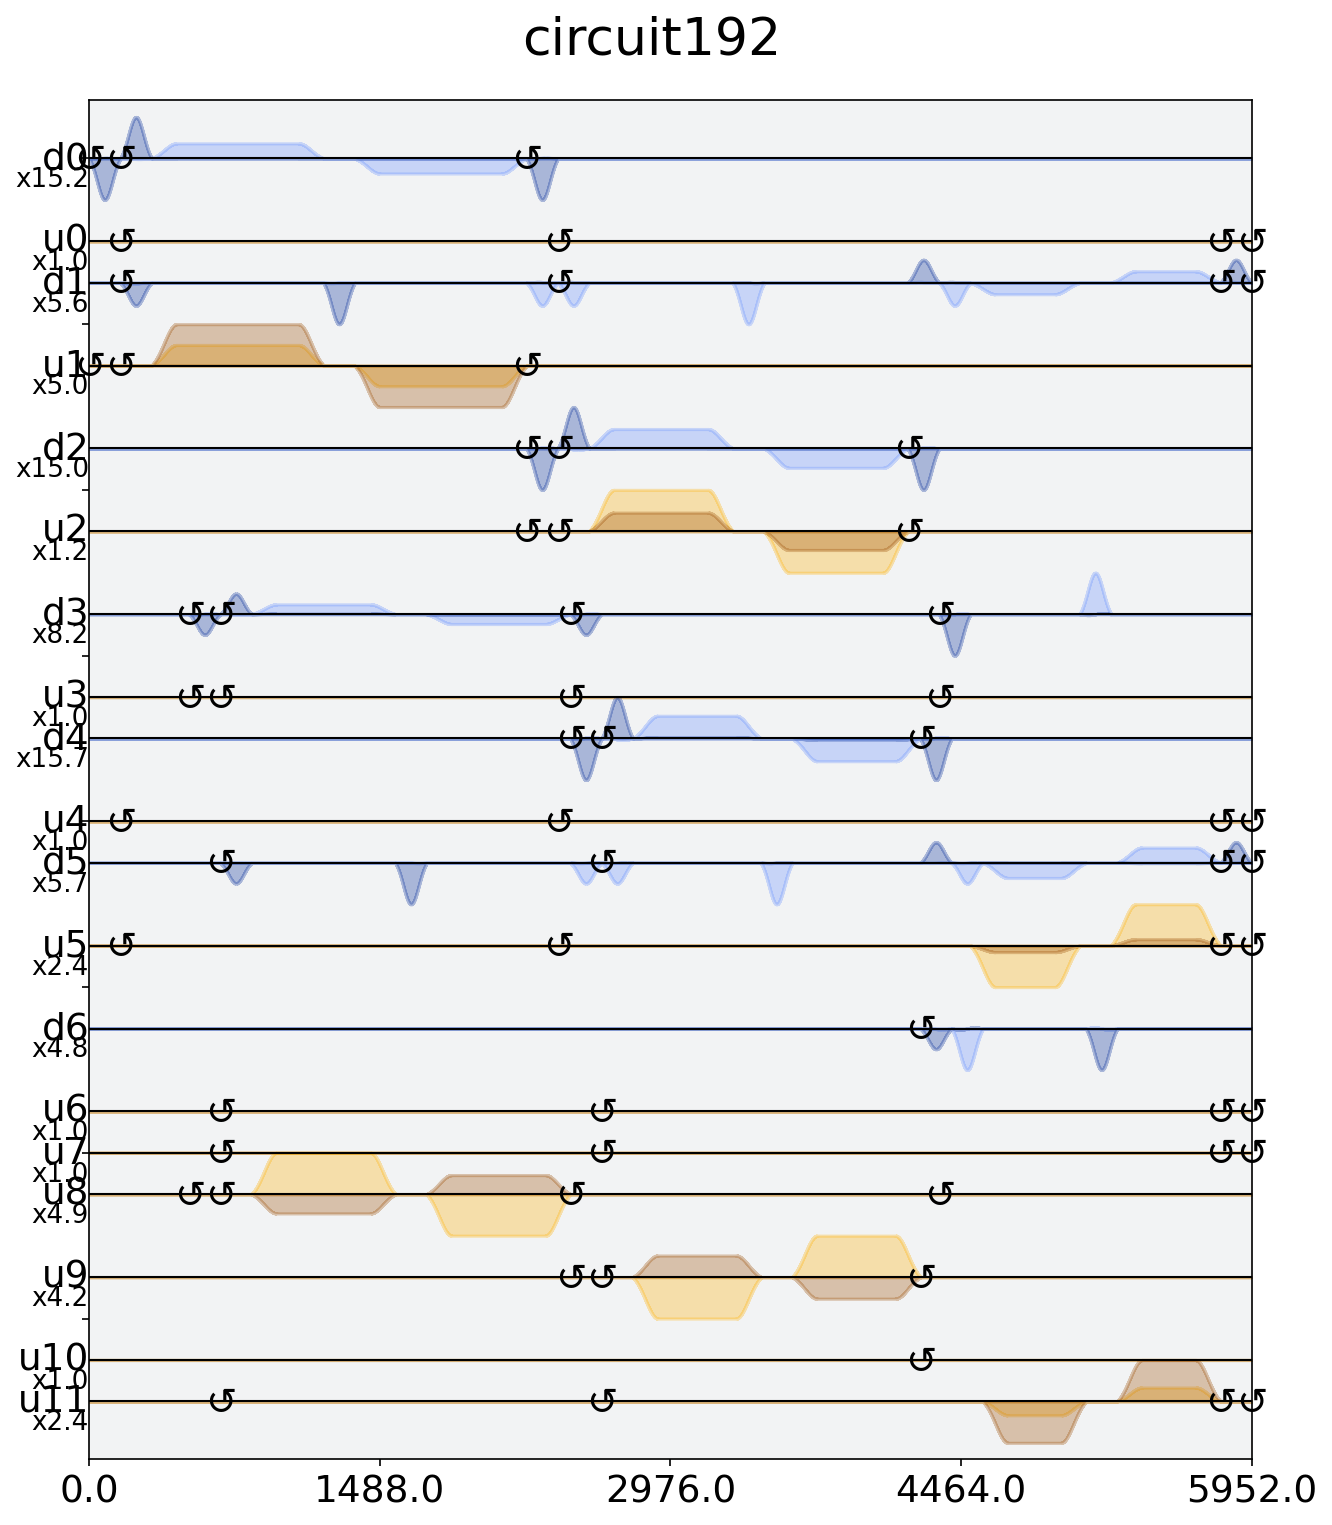

In [7]:
back_defaults = backend.defaults()

inst_map = back_defaults.instruction_schedule_map

sched = schedule(transpile(state_circuit, backend, optimization_level = 1), backend, inst_map=inst_map)
sched.draw()#plot_range=(0, 6000))


## Creating and measuring stabilizers (unchanged)

We begin by defining functions to create stabilizer measurement circuits, and then appending them onto the circuit used to create the graph states. This part is unchanged from the default code provided.

In [8]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement circuits.
    
    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.
    
    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ

In [9]:
## Compute the stabilizers for this graph state
generators = qi.Clifford(state_circuit).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit)
print('Stabilizers:', stabilizers)
print('Generators:', generators)

Stabilizers: ['+IIIIIII', '+IIIIIZX', '+IIIIXIX', '+IIIIXZI', '-IIIZYXY', '+IIIZYYZ', '+IIIZZXZ', '+IIIZZYY', '+IIXXIIX', '+IIXXIZI', '+IIXXXII', '+IIXXXZX', '-IIXYYXZ', '-IIXYYYY', '-IIXYZXY', '+IIXYZYZ', '+IZIXIIX', '+IZIXIZI', '+IZIXXII', '+IZIXXZX', '-IZIYYXZ', '-IZIYYYY', '-IZIYZXY', '+IZIYZYZ', '+IZXIIII', '+IZXIIZX', '+IZXIXIX', '+IZXIXZI', '-IZXZYXY', '+IZXZYYZ', '+IZXZZXZ', '+IZXZZYY', '+XIIXIIX', '+XIIXIZI', '+XIIXXII', '+XIIXXZX', '-XIIYYXZ', '-XIIYYYY', '-XIIYZXY', '+XIIYZYZ', '+XIXIIII', '+XIXIIZX', '+XIXIXIX', '+XIXIXZI', '-XIXZYXY', '+XIXZYYZ', '+XIXZZXZ', '+XIXZZYY', '+XZIIIII', '+XZIIIZX', '+XZIIXIX', '+XZIIXZI', '-XZIZYXY', '+XZIZYYZ', '+XZIZZXZ', '+XZIZZYY', '+XZXXIIX', '+XZXXIZI', '+XZXXXII', '+XZXXXZX', '-XZXYYXZ', '-XZXYYYY', '-XZXYZXY', '+XZXYZYZ', '+YXYIYXY', '-YXYIYYZ', '-YXYIZXZ', '-YXYIZYY', '-YXYZIII', '-YXYZIZX', '-YXYZXIX', '-YXYZXZI', '-YXZXYXZ', '-YXZXYYY', '-YXZXZXY', '+YXZXZYZ', '-YXZYIIX', '-YXZYIZI', '-YXZYXII', '-YXZYXZX', '-YYYXYXZ', '-YYYXYYY', '-

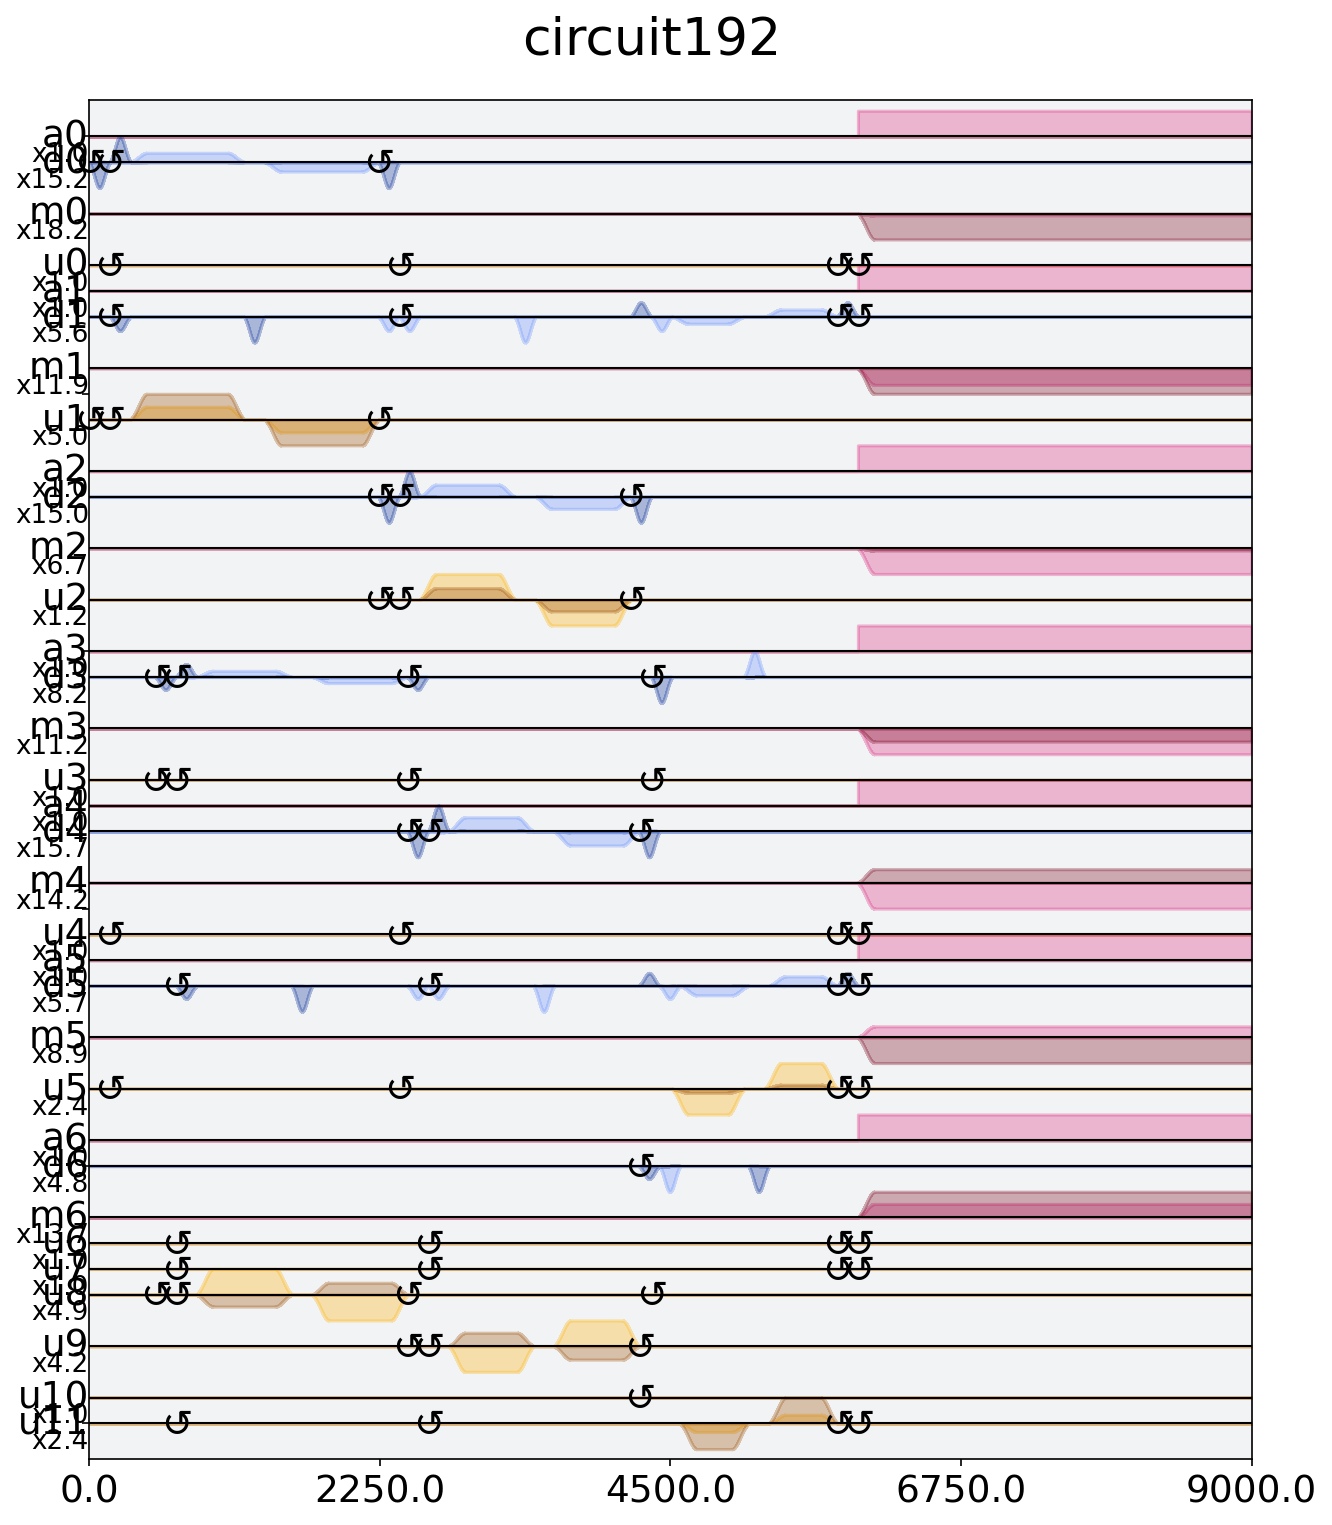

In [10]:
stabilizer_circuits = [transpile(stabilizer_measure_circuit(stab, state_circuit),backend, optimization_level = 1)
                       for stab in stabilizers]

# see a sample stabilizer circuit pulse schedule
sched = schedule(stabilizer_circuits[0], backend, inst_map=inst_map)
sched.draw(plot_range=(0, 9000),interactive= True, plot_all = True)


## Measurement mitigation

We did not change the measurement mitigation methods, we used 'complete' for our experimental result below, but using 'tensored' or 'CTMP' does not change the mitigated fidelity significantly, though we've observed that 'tensored' does lead to slightly higher mitigated fidelity in practice. 

In [11]:
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, method = 'complete')

In [12]:
[meas_cal_circuits_full, state_labels] = mit.complete_meas_cal(range(num_qubits))

## Run / retrieve our optimized circuits results

We ran the circuits on the `ibmq_casablanca` quantum system previously and will simply retrieve the results using job IDs here. For the judges who are re-creating the results, please uncomment the job creation part and submit job and retrieve those results independently.

We run the measurement calibration circuits in a separate job from the graph state circuits.  We repeat both 16 times and use the mean as the final value. 

In [13]:
# we retrieve our previous results (using the job ID msg) here:

msg = """
Job IDs (1/16): 
 measurement calibration: 603a61a3ead6ee2ea6edcba4
 stabilizer measurements: 603a61a16ebbe16d1371f0f5
Job IDs (2/16): 
 measurement calibration: 603a61a9a62407694fc8a419
 stabilizer measurements: 603a61a75728cef54b2be715
Job IDs (3/16): 
 measurement calibration: 603a61af6760ce1a6560cc5a
 stabilizer measurements: 603a61ad8c2165fff242d2ac
Job IDs (4/16): 
 measurement calibration: 603a61b55728ce30842be717
 stabilizer measurements: 603a61b4fcca6b33494c6082
Job IDs (5/16): 
 measurement calibration: 603a61bbc6d1d179d3f998de
 stabilizer measurements: 603a61b96ebbe1338171f0f8
Job IDs (6/16): 
 measurement calibration: 603a61c1fcca6b86e54c6084
 stabilizer measurements: 603a61bfa624073dfdc8a41c
Job IDs (7/16): 
 measurement calibration: 603a61c7c6d1d17877f998e0
 stabilizer measurements: 603a61c56760cef9e660cc5e
Job IDs (8/16): 
 measurement calibration: 603a61ccc6d1d1cb36f998e1
 stabilizer measurements: 603a61cbe8504d2d1e3eba73
Job IDs (9/16): 
 measurement calibration: 603a61d28c21656a7d42d2ae
 stabilizer measurements: 603a61d1a624075b98c8a41f
Job IDs (10/16): 
 measurement calibration: 603a61d8a6240798e0c8a421
 stabilizer measurements: 603a61d65728ce804d2be719
Job IDs (11/16): 
 measurement calibration: 603a61e0a624075e22c8a423
 stabilizer measurements: 603a61de742e5347d4801b44
Job IDs (12/16): 
 measurement calibration: 603a61e76760ce92a860cc61
 stabilizer measurements: 603a61e68c21657f9d42d2af
Job IDs (13/16): 
 measurement calibration: 603a61edead6ee6070edcba8
 stabilizer measurements: 603a61ebfcca6b62e64c6088
Job IDs (14/16): 
 measurement calibration: 603a61f2c6d1d18df1f998e4
 stabilizer measurements: 603a61f16760ce0a7a60cc62
Job IDs (15/16): 
 measurement calibration: 603a61f8c6d1d18051f998e6
 stabilizer measurements: 603a61f68c2165055d42d2b1
Job IDs (16/16): 
 measurement calibration: 603a61fe5728ce78972be71d
 stabilizer measurements: 603a61fc6760cece1960cc65
"""

reps = 16
all_jobs = []
all_jobs_mit = []

for i in msg.split('\n'):
    if i[:26] == " measurement calibration: ":
        all_jobs_mit.append(backend.retrieve_job(i[26:]))
    elif i[:26] == " stabilizer measurements: ":
        all_jobs.append(backend.retrieve_job(i[26:]))



"\nreps = 16\n\nall_jobs = []\nall_jobs_mit = []\n\nfor ii in range(reps):\n\n    # Run QPT on backend\n    shots = 8192\n    il = [0,1,2,3,4,5,6]\n    \n    job_backend = execute(stabilizer_circuits, backend, shots=shots, initial_layout=il)\n    job_mit_backend = execute(meas_cal_circuits, backend, shots=shots, initial_layout=il)\n    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(\n        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))\n\n    all_jobs.append(job_backend)\n    all_jobs_mit.append(job_mit_backend)\n"

### For the judges who are re-creating the results, please uncomment the cell below

In [ ]:
### For judges to reproduce the results: 
## Uncomment below to run the circuits
'''
reps = 16

all_jobs = []
all_jobs_mit = []

for ii in range(reps):

    # Run QPT on backend
    shots = 8192
    il = [0,1,2,3,4,5,6]
    
    job_backend = execute(stabilizer_circuits, backend, shots=shots, initial_layout=il)
    job_mit_backend = execute(meas_cal_circuits, backend, shots=shots, initial_layout=il)
    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(
        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))

    all_jobs.append(job_backend)
    all_jobs_mit.append(job_mit_backend)
'''


We can monitor the status of the jobs using Qiskit's job monitoring tools.

In [14]:
for job in all_jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


Once the jobs are completed, we can get the results back as follows.

In [15]:
result_backend = []
result_mit_backend = []

for job in all_jobs:
    # Retrieve results (this may take a while depending on the queue)
    result_backend.append(job.result())
    
for job in all_jobs_mit:
    result_mit_backend.append(job.result())

This is all unchanged from the default: 

Finally, we compute the fidelities of the graph states. You may consider creating your own method for error mitigation by updating the `stabilizer_expvals` function below. Here, we will use the default methods provided in Qiskit.

In [16]:
def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.
    
    Args:
        stabilizer (str): a stabilizer string
    
    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag
    
def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev

This is all unchanged from the default:

In [17]:
def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""

    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)
        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)

In [18]:
## Mitigate the stabilizer expectation values 
F_nomit_backend = []
F_mit_backend = []

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
  
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()

    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    
    # save the fidelities for this iteration
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

## Our optimized (with Strategy I) fidelity with 'complete' error mitigation is 96%, with error bar of 1.8%. 

#### See other notebook for how using 'tensored' mitigation over-estimates the fidelity, giving about 105%. This is expected from the work of [1].

[1] S. Bravyi, S. Sheldon, A. Kandala, D.C. McKay, J.M. Gambetta, Mitigating measurement errors in multi-qubit experiments, arXiv:2006.14044 (2020).

In [19]:
## The final experimental fidelity with step I optimization 

print('Graph-state fidelity estimates')
print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nComplete error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))

Graph-state fidelity estimates

No mitigation
F(ibmq_casablanca) = 0.729 ± 0.011

Complete error mitigation
F(ibmq_casablanca) = 0.960 ± 0.018


# The following sections on Strategies II. gate sequence optimization and III. dynamical decoupling is run on simulator only because of significant errors on the IBM Casablanca chip. 

### Judges are welcome to run these experimentally (by commenting out the line below) if IBM Casablanca has returned to normal levels of error at the time of judging.

In [20]:
backend = QasmSimulator.from_backend(provider.get_backend('ibmq_casablanca'))

## Stragey II. Optimized gate sequence to minimize qubit decoherence
#### i.e. leave qubits with lowest T2 to be operated on last

In [22]:
def create_optimized_graph_state_II():
    ''' 
    Create our optimized graph state circuit, in addition to optimization in I, 
    this step II will optimize gate ordering such that qubits with lowest T2 will be operated on last
    (which effectively lengthens their T2 since they cannot dephase before their first gate)
    '''
    
    state_circuit = QuantumCircuit(7)
    state_circuit.h(0)
    state_circuit.h(2)
    state_circuit.h(3)
    state_circuit.h(4)
    state_circuit.h(6)
    
    
    # get top qubit 0,2,3 ordered in smallest -> largest T2
    qubit_order_top = [qubit for T2, qubit in sorted(zip([backend.properties().t2(0),backend.properties().t2(2),backend.properties().t2(3)], [0,2,3]))]
    
    # get bot qubit 3,4,6 ordered in largest -> smallest T2
    qubit_order_bot = [qubit for T2, qubit in sorted(zip([backend.properties().t2(3),backend.properties().t2(4),backend.properties().t2(6)], [3,4,6]))]
    
    # qubit 3 may be at the same position in top & bot, may need to re-arrange: 
    if (qubit_order_top.index(3) == qubit_order_bot.index(3)):
        index_q3 = qubit_order_top.index(3)
        
        if (index_q3 == 2): # if qubit 3 at last index, swap with index 1
            qubit_order_top[1], qubit_order_top[2] = qubit_order_top[2], qubit_order_top[1]
            
        else:              # otherwise swap with later index
            qubit_order_top[index_q3], qubit_order_top[index_q3+1] = qubit_order_top[index_q3+1], qubit_order_top[index_q3]
    
    
    # two qubit gates involving qubit 1 (top half of Casablanca), run in order of decreasing T2, in parallel with
    # two qubit gates involving qubit 5 (bottom half of Casablanca), run in order of decreasing T2
    state_circuit.cx(qubit_order_top[-1], 1)
    state_circuit.cx(qubit_order_bot[-1], 5)
    state_circuit.cx(qubit_order_top[-2], 1)
    state_circuit.cx(qubit_order_bot[-2], 5)
    state_circuit.cx(qubit_order_top[-3], 1)
    state_circuit.cx(qubit_order_bot[-3], 5)
    
    state_circuit.h(1)
    state_circuit.h(5)
    
    return state_circuit

state_circuit = create_optimized_graph_state_II()
state_circuit.draw()

## Notice how we run two sets of CX in parallel at each level and 
## set qubit 1 and 5 such that many Hadamards (part of CZ) are cancelled there

┌───┐                    
q_0: ┤ H ├───────■────────────
     └───┘┌───┐┌─┴─┐┌───┐┌───┐
q_1: ─────┤ X ├┤ X ├┤ X ├┤ H ├
     ┌───┐└─┬─┘└───┘└─┬─┘└───┘
q_2: ┤ H ├──■─────────┼───────
     ├───┤            │       
q_3: ┤ H ├───────■────■───────
     ├───┤       │            
q_4: ┤ H ├───────┼────■───────
     └───┘┌───┐┌─┴─┐┌─┴─┐┌───┐
q_5: ─────┤ X ├┤ X ├┤ X ├┤ H ├
     ┌───┐└─┬─┘└───┘└───┘└───┘
q_6: ┤ H ├──■─────────────────
     └───┘

#### Everything else is unchanged

In [23]:
## Compute the stabilizers for this graph state
generators = qi.Clifford(state_circuit).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit)
print('Stabilizers:', stabilizers)
print('Generators:', generators)

Stabilizers: ['+IIIIIII', '+IIIIIZX', '+IIIIXIX', '+IIIIXZI', '-IIIZYXY', '+IIIZYYZ', '+IIIZZXZ', '+IIIZZYY', '+IIXXIIX', '+IIXXIZI', '+IIXXXII', '+IIXXXZX', '-IIXYYXZ', '-IIXYYYY', '-IIXYZXY', '+IIXYZYZ', '+IZIXIIX', '+IZIXIZI', '+IZIXXII', '+IZIXXZX', '-IZIYYXZ', '-IZIYYYY', '-IZIYZXY', '+IZIYZYZ', '+IZXIIII', '+IZXIIZX', '+IZXIXIX', '+IZXIXZI', '-IZXZYXY', '+IZXZYYZ', '+IZXZZXZ', '+IZXZZYY', '+XIIXIIX', '+XIIXIZI', '+XIIXXII', '+XIIXXZX', '-XIIYYXZ', '-XIIYYYY', '-XIIYZXY', '+XIIYZYZ', '+XIXIIII', '+XIXIIZX', '+XIXIXIX', '+XIXIXZI', '-XIXZYXY', '+XIXZYYZ', '+XIXZZXZ', '+XIXZZYY', '+XZIIIII', '+XZIIIZX', '+XZIIXIX', '+XZIIXZI', '-XZIZYXY', '+XZIZYYZ', '+XZIZZXZ', '+XZIZZYY', '+XZXXIIX', '+XZXXIZI', '+XZXXXII', '+XZXXXZX', '-XZXYYXZ', '-XZXYYYY', '-XZXYZXY', '+XZXYZYZ', '+YXYIYXY', '-YXYIYYZ', '-YXYIZXZ', '-YXYIZYY', '-YXYZIII', '-YXYZIZX', '-YXYZXIX', '-YXYZXZI', '-YXZXYXZ', '-YXZXYYY', '-YXZXZXY', '+YXZXZYZ', '-YXZYIIX', '-YXZYIZI', '-YXZYXII', '-YXZYXZX', '-YYYXYXZ', '-YYYXYYY', '-

In [24]:
stabilizer_circuits = [transpile(stabilizer_measure_circuit(stab, state_circuit),backend, optimization_level = 1)
                       for stab in stabilizers]

## see a sample stabilizer circuit pulse schedule
#sched = schedule(stabilizer_circuits[0], backend, inst_map=inst_map)
#sched.draw(plot_range=(0, 9000),interactive= True, plot_all = True)


In [25]:
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, method = 'complete')

In [26]:
[meas_cal_circuits_full, state_labels] = mit.complete_meas_cal(range(num_qubits))

In [27]:
reps = 16

all_jobs = []
all_jobs_mit = []

for ii in range(reps):

    # Run QPT on backend
    shots = 8192
    il = [0,1,2,3,4,5,6]
    
    job_backend = execute(stabilizer_circuits, backend, shots=shots, initial_layout=il)
    job_mit_backend = execute(meas_cal_circuits, backend, shots=shots, initial_layout=il)
    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(
        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))

    all_jobs.append(job_backend)
    all_jobs_mit.append(job_mit_backend)


Job IDs (1/16): 
 measurement calibration: e4ee240a-f600-4205-8eb7-b87ffa421636
 stabilizer measurements: 3ec1c49f-c194-470d-82bb-ed93be83032b
Job IDs (2/16): 
 measurement calibration: 8003d118-4523-41ab-8c76-85d9021e25d4
 stabilizer measurements: 422f5b7e-df90-4410-941c-56df0aa7dfff
Job IDs (3/16): 
 measurement calibration: 89baade9-f4b1-47b2-bd2b-e8046195eb41
 stabilizer measurements: 190f23c2-aafb-444b-addf-fde108051b65
Job IDs (4/16): 
 measurement calibration: 55d05e20-2d95-4bc4-ac0b-9097a399ffaa
 stabilizer measurements: 2071d49c-da20-4c17-b8cf-dfc0758f4be4
Job IDs (5/16): 
 measurement calibration: ec7fb918-8dd2-41bf-aa68-744777aabe4d
 stabilizer measurements: d822839f-c7e6-4977-9d8a-2fa4943ea732
Job IDs (6/16): 
 measurement calibration: 9159e646-bba6-4d0b-a1bd-1a90042ceec5
 stabilizer measurements: 8d67689c-a759-4b13-bd2b-eac124a47976
Job IDs (7/16): 
 measurement calibration: 67426c6c-6819-4d17-9452-ee09a3289183
 stabilizer measurements: bae9c605-9e6b-4a59-b124-6f13bd99e3a0

In [28]:
for job in all_jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [29]:
result_backend = []
result_mit_backend = []

for job in all_jobs:
    # Retrieve results (this may take a while depending on the queue)
    result_backend.append(job.result())
    
for job in all_jobs_mit:
    result_mit_backend.append(job.result())

In [30]:
## Mitigate the stabilizer expectation values 
F_nomit_backend = []
F_mit_backend = []

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
  
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()

    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    
    # save the fidelities for this iteration
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

### Simulated fidelity results using optimization strategies I & II

##### When compared to simulated step I only results, there is about 0.2% improvement. On the real device it could be higher.  

In [31]:
print('Graph-state fidelity estimates')
print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nComplete error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))

Graph-state fidelity estimates

No mitigation
F(ibmq_casablanca) = 0.537 ± 0.001

Complete error mitigation
F(ibmq_casablanca) = 0.901 ± 0.002


### III. Add dynamical decoupling 

#### We use the same echo sequence which was found to be optimal in [2]

[2] Petar Jurcevic et al 2021 Quantum Sci. Technol. 6 025020

Once the jobs are completed, we can get the results back as follows.

In [32]:
def pad_id_gates(circuit, qubit, num_of_id_gates):
    """
    A function for padding a circuit with single-qubit identity gates.
    Args:
        circuit (QuantumCircuit): the quantum circuit that the gates should be
            appended to
        qubit (int): index of qubit where the gates should be added
        num_of_id_gates (int): the number of identity gates to add
    Returns:
        circuit: The original circuit object, but with identity
            gates added to the qubit register qr at qubit 'qubit'
    """

    for _ in range(num_of_id_gates):
        circuit.barrier(qubit)
        # Maintain compatibility with 0.12 stable terra
        # the case of .iden should be removed once terra 0.13 is stable
        if hasattr(circuit, 'i'):
            circuit.i(qubit)
        else:
            circuit.iden(qubit)

    circuit.barrier(qubit)
    return circuit

def get_X_times(qubits):
    ''' Return all the X gate durations for qubits specified, in backend '''
    
    inst_map = back_defaults.instruction_schedule_map
    
    # the 2 here accounts for the fact that only pi/2 pulse is 160 ns, but pi pulse needs two pi/2 pulses.
    X_times = [2*inst_map.get('x', qubit, np.pi).duration for qubit in qubits] # these are always 160 ns
    
    return X_times

def echoed_circuits(stabilizer_circuits):
    """Return echoed circuits.
    
    Args:
        stabilizer_circuits: a list with initial circuits with measurements.
    
    Returns:
        QuantumCircuit: the circuits with echoe.
    """
    
    to_return = []    
        
    X_times = get_X_times(list(range(num_qubits)))
    #print(X_times) # all 160 ns

    for _ in stabilizer_circuits:
        
        stab_circ = _.copy()
        
        # remove measurements
        stab_circ.remove_final_measurements(inplace=True)

        # compute idle time
        sched = schedule(stab_circ, backend, inst_map=inst_map)
        total_time = sched.duration


        for qubit_i in range(num_qubits):
            idle_time = total_time - sched.ch_duration(pulse.DriveChannel(qubit_i))  

            if (idle_time > 7*160): # need at least 8 instructions of 160ns each
                delay_time = (idle_time - 2*X_times[qubit_i])

                delay_id_gates = delay_time / 160

                num_of_id_gates = int(delay_id_gates / 4)
                
                # echoe
                stab_circ = pad_id_gates(stab_circ, qubit_i, num_of_id_gates=num_of_id_gates) # 1 delay
                stab_circ.rx(np.pi, qubit_i) # positive rotation
                stab_circ = pad_id_gates(stab_circ, qubit_i, num_of_id_gates=num_of_id_gates*2) # 2 delay
                stab_circ.rx(-np.pi, qubit_i) # negative rotation
                stab_circ = pad_id_gates(stab_circ, qubit_i, num_of_id_gates=num_of_id_gates) # 1 delay

        # add back measurements
        stab_circ.measure_all()
            
        to_return.append(stab_circ)
        
    return to_return

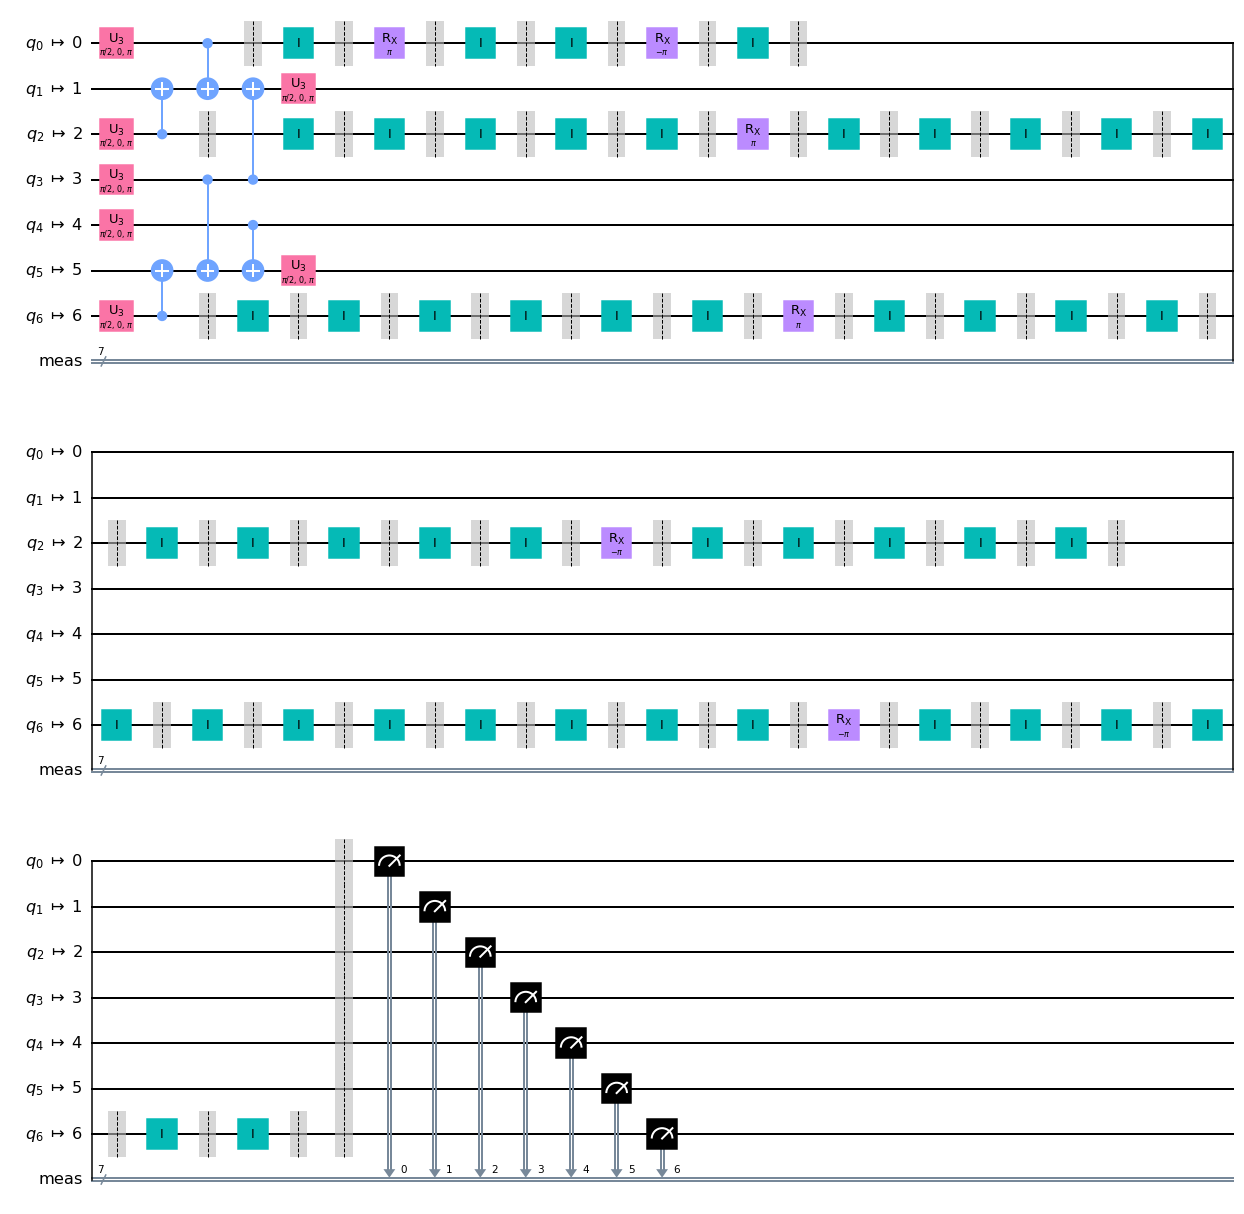

In [33]:
# add dynamical decoupling (echo) the circuits we got from previous sections 
echoed_stabilizer_circuits = echoed_circuits(stabilizer_circuits)

#stabilizer_circuit = transpile(stabilizer_circuit,backend, optimization_level = 1)
echoed_stabilizer_circuits[0].draw('mpl') # draw example

#### Everything else is unchanged

In [34]:
transpiled_echoed_stabilizer_circuits = [transpile(stab_cct, backend, optimization_level = 1) for stab_cct in echoed_stabilizer_circuits]
sched = schedule(transpiled_echoed_stabilizer_circuits[0], backend, inst_map=inst_map)

#sched.draw()#plot_range=(0, 7000))

In [35]:
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, method = 'complete')

In [36]:
[meas_cal_circuits_full, state_labels] = mit.complete_meas_cal(range(num_qubits))

In [37]:
reps = 16

all_jobs = []
all_jobs_mit = []

for ii in range(reps):

    # Run QPT on backend
    shots = 8192
    il = [0,1,2,3,4,5,6]
    
    job_backend = execute(transpiled_echoed_stabilizer_circuits, backend, shots=shots, initial_layout=il)
    job_mit_backend = execute(meas_cal_circuits, backend, shots=shots, initial_layout=il)
    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(
        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))

    all_jobs.append(job_backend)
    all_jobs_mit.append(job_mit_backend)


Job IDs (1/16): 
 measurement calibration: 81c6d6ef-ecab-40ae-ab53-7bc454747a2d
 stabilizer measurements: eb58ee84-e1c5-4f51-ad0c-983153e85238
Job IDs (2/16): 
 measurement calibration: 193e100d-b62b-4fcd-a163-dc3594c17c07
 stabilizer measurements: c95563f4-c684-4c6d-a00b-c12e94baf345
Job IDs (3/16): 
 measurement calibration: a38c0e13-b13b-4e24-82e0-c005272dbbcc
 stabilizer measurements: 47d72229-d15b-4b46-8a1b-2d0354fcb5cd
Job IDs (4/16): 
 measurement calibration: f107d223-8328-4a58-80e2-01782ba8f472
 stabilizer measurements: 075895d8-cbdf-48b9-827c-e43102077e0f
Job IDs (5/16): 
 measurement calibration: e9296475-faf9-4ce4-a588-27391481306a
 stabilizer measurements: e32bc6e3-37b6-40c8-89bf-c97711210bdd
Job IDs (6/16): 
 measurement calibration: ac8abe7d-7a10-4490-9ebe-889023c1608b
 stabilizer measurements: 81e1fc61-b8a3-4863-9640-71561fd225bf
Job IDs (7/16): 
 measurement calibration: b92d84fe-df45-4e07-ae65-0e0ce94224da
 stabilizer measurements: 481ee31e-f50d-4b56-a9d3-d9ab9a694330

In [38]:
for job in all_jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [39]:
result_backend = []
result_mit_backend = []

for job in all_jobs:
    # Retrieve results (this may take a while depending on the queue)
    result_backend.append(job.result())
    
for job in all_jobs_mit:
    result_mit_backend.append(job.result())

In [40]:
## Mitigate the stabilizer expectation values 
F_nomit_backend = []
F_mit_backend = []

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
  
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()

    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    
    # save the fidelities for this iteration
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

## The simulated fidelity with all strategies I, II, and III optimization. 

##### The QASM simulator doesn't account for experimental cross-talk so the dynamical decoupling improvements cannot be seen. The improvements could be apparent in an experimental run

In [41]:
## The final simulated fidelity with step I, II, III optimization 

print('Graph-state fidelity estimates')
print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nComplete error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))

Graph-state fidelity estimates

No mitigation
F(ibmq_casablanca) = 0.514 ± 0.001

Complete error mitigation
F(ibmq_casablanca) = 0.853 ± 0.002


## Qiskit version

In [42]:
import qiskit.tools.jupyter
%qiskit_version_table